### 1a)
Пространство фичей разбивается на две части: $\le a$ и $\geq a$
Тогда максимальное число разбиений $n-1$, где n - число точек.
Еще два тривиальных, когда все больеш или все меньше.
Итого, $m_h(n)=n+1$, $BP=2$, $d_{VC}(h)=1$

### 1б)
Аналогично предыдущему, только теперь надо в отстортированный список
по значению фичи поставить точки $a$ и $b$.
И еще одно, когда между $a$ и $b$ ничего не попало.
Итого, $m_h(n)=\frac{(n+1)n}{2}+1$, $BP=3$, $d_{VC}(h)=2$

In [2]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
# у меня под вечер сломалась панда, опять все идет не по плану, надеюсь остальное выживет
#import pandas as pd
import csv
from sklearn.model_selection import train_test_split
data_folder = "../models/"

In [3]:
def read_blobs2():
    data = []
    
    with open(data_folder + "blobs2.csv", newline='') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        next(dataset_reader)
        for row in dataset_reader:
            row = list(map(float, row))
            data.append(np.array([np.array(row[:-1]), row[-1]]))

    return np.array(data)


In [4]:
def extract_labels(data):
    values = np.array([row[0] for row in data])
    labels = np.array([row[1] for row in data])
    
    return values, labels


In [5]:
blobs2_values, blobs2_labels = extract_labels(read_blobs2())

In [6]:
def split_dataset(values, labels):
    values_train, values_test, labels_train, labels_test = train_test_split(values, labels, train_size=0.8)  
    return values_train, values_test, labels_train, labels_test


In [7]:
def split_dataset_poly(values, labels, deg):
    values_train, values_test, labels_train, labels_test = train_test_split(values, labels, train_size=0.8)  
    return PolynomialFeatures(degree=deg).fit_transform(values_train),\
           PolynomialFeatures(degree=deg).fit_transform(values_test),\
           labels_train,\
           labels_test

In [12]:
def pocket(deg, epochs):
    def h(w_inner, x_inner):
        return 0 if np.sign(w_inner @ x_inner) < 0 else 1
    values_train, values_test, labels_train, labels_test = split_dataset_poly(blobs2_values, blobs2_labels, deg)
    w = np.random.rand(len(values_train[0]))
    res, min_error = None, None
        
    for _ in range(epochs):
        for val, lab in zip(values_train, labels_train):
            if h(w, val) == lab:
                continue
            w += np.sign(lab - 0.5) * val
            cnt = 0.0
            for val_test, lab_test in zip(values_test, labels_test):
                if h(w, val_test) != lab_test:
                    cnt += 1.0
                    
            err = cnt / len(values_test)
            if min_error is None or err < min_error:
                res = w
                min_error = err
                
    
    return lambda value: h(res, value)


In [8]:
import matplotlib.pyplot as plt

# https://stats.stackexchange.com/questions/71335/decision-boundary-plot-for-a-perceptron
def draw(h, degree):
    X, Y = blobs2_values, blobs2_labels
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                     np.arange(y_min, y_max, .02))
    fig, ax = plt.subplots()
    Z = np.array([h(x) for x in PolynomialFeatures(degree=degree).fit_transform(np.c_[xx.ravel(), yy.ravel()])])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.spring, alpha=0.6)
    ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.spring, s=15, edgecolors='k')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.show()

F:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


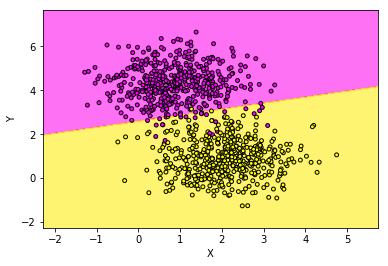

In [14]:
def task2():
    h = pocket(1, 100)
    draw(h, 1)
    
task2()


F:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


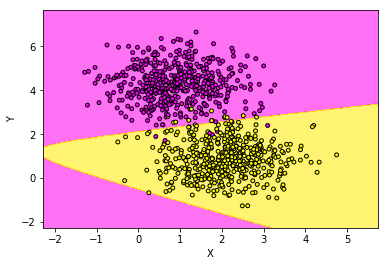

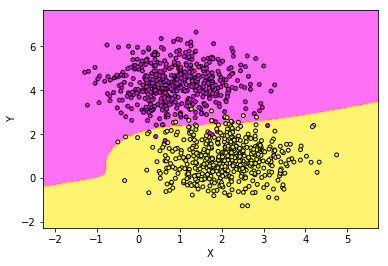

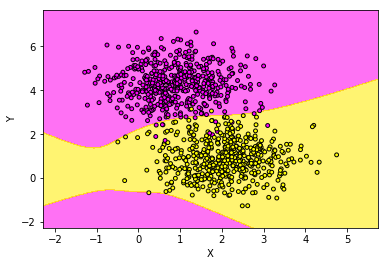

In [16]:
def task3():
    for deg in range(2, 5):
        h = pocket(deg, 100)
        draw(h, deg)
        
task3()


In [9]:
from sklearn.preprocessing import MinMaxScaler
    
def logistic_regression(values, labels, epochs, batch_size):
    values = MinMaxScaler().fit_transform(values)
    mark = labels[0]
    labels = list(map(lambda lab: -1 if lab == mark else 1, labels))
    w = np.random.rand(len(values[0]))
    batches_count = (len(values) + batch_size - 1) // batch_size
    res = []
    
    for i in range(epochs):
        for j in range(batches_count):
            batch = range(batch_size * j, min(batch_size * (j + 1), len(values)))
            s = 0
            for k in batch:
                s += labels[k] * values[k] / (1 + np.exp(labels[k] * (w @ values[k])))
            
            w += s / len(batch)
        
        res.append(np.mean(np.array([-1 if 1 / (1 + np.exp(-(w @ val))) < 0.5 else 1 for val in values]) == labels))
    return res


In [10]:

def draw_regr(res):
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.plot(list(range(len(res))), res)
    plt.show()


In [11]:
def read_spam():
    data = []
    
    with open(data_folder + "spam.csv", newline='') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        next(dataset_reader)
        for row in dataset_reader:
            row = list(map(float, row))
            data.append(np.array([np.array(row[:-1]), row[-1]]))

    return np.array(data)

def read_cancer():
    data = []
    
    with open(data_folder + "cancer.csv", newline='') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        next(dataset_reader)
        for row in dataset_reader:
            data.append(np.array([np.array(list(map(float, row[1:]))), row[0]]))

    return np.array(data)

In [21]:
spam_values, spam_labels = extract_labels(read_spam())
cancer_values, cancer_labels = extract_labels(read_cancer())


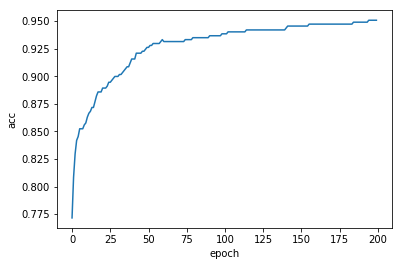

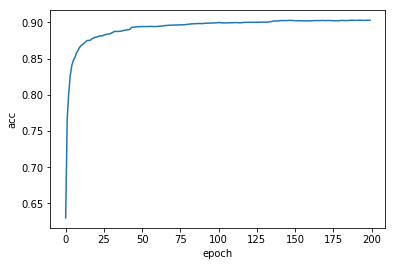

In [22]:
def task4_spam():
    epochs = 200
    batch_size = 32
    acc = logistic_regression(spam_values, spam_labels, epochs, batch_size)
    draw_regr(acc)

def task4_cancer():
    epochs = 200
    batch_size = 32
    acc = logistic_regression(cancer_values, cancer_labels, epochs, batch_size)
    draw_regr(acc)

task4_cancer()
task4_spam()


In [12]:
import torch


In [31]:
def read_mnist():
    data = []
    
    with open(data_folder + "mnist.csv", newline='') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        next(dataset_reader)
        for row in dataset_reader:
            data.append(np.array([np.array(list(map(int, row[1:]))), int(row[0])]))

    return np.array(data)


In [32]:
def load_mnist():
    mnist_values, mnist_labels = extract_labels(read_mnist()) #  read_data("mnist.csv")
    mnist_values = torch.tensor(mnist_values, dtype=torch.float).view(mnist_values.shape[0], 1, 28, 28)
    mnist_labels = torch.tensor(mnist_labels, dtype=torch.long)
    return mnist_values, mnist_labels


In [33]:
def load_mnist_ttv():
    mnist_values, mnist_labels = extract_labels(read_mnist())
    mnist_values_train, mnist_values_test, mnist_labels_train, mnist_labels_test = split_dataset(mnist_values, mnist_labels)
    mnist_values_train, mnist_values_validate, mnist_labels_train, mnist_labels_validate = split_dataset(mnist_values_train, mnist_labels_train)
    mnist_values_train = torch.tensor(mnist_values_train, dtype=torch.float).view(mnist_values_train.shape[0], 1, 28, 28)
    mnist_labels_train = torch.tensor(mnist_labels_train, dtype=torch.long)
    mnist_values_test = torch.tensor(mnist_values_test, dtype=torch.float).view(mnist_values_test.shape[0], 1, 28, 28)
    mnist_labels_test = torch.tensor(mnist_labels_test, dtype=torch.long)
    mnist_values_validate = torch.tensor(mnist_values_validate, dtype=torch.float).view(mnist_values_validate.shape[0], 1, 28, 28)
    mnist_labels_validate = torch.tensor(mnist_labels_validate, dtype=torch.long)
    return mnist_values_train, mnist_values_test, mnist_values_validate, mnist_labels_train, mnist_labels_test, mnist_labels_validate

In [34]:
def load_mnist_ttv_normalised():
    mnist_values, mnist_labels = extract_labels(read_mnist())
    mnist_values_train, mnist_values_test, mnist_labels_train, mnist_labels_test = split_dataset(mnist_values, mnist_labels)
    mnist_values_train, mnist_values_validate, mnist_labels_train, mnist_labels_validate = split_dataset(mnist_values_train, mnist_labels_train)
    mnist_values_train = torch.tensor(mnist_values_train, dtype=torch.float).view(mnist_values_train.shape[0], 1, 28, 28)
    mnist_labels_train = torch.tensor(mnist_labels_train, dtype=torch.long)
    mnist_values_test = torch.tensor(mnist_values_test, dtype=torch.float).view(mnist_values_test.shape[0], 1, 28, 28)
    mnist_labels_test = torch.tensor(mnist_labels_test, dtype=torch.long)
    mnist_values_validate = torch.tensor(mnist_values_validate, dtype=torch.float).view(mnist_values_validate.shape[0], 1, 28, 28)
    mnist_labels_validate = torch.tensor(mnist_labels_validate, dtype=torch.long)
    mnist_values_train /= 255
    mnist_values_train = 2 * mnist_values_train - 1
    mnist_values_test /= 255
    mnist_values_test = 2 * mnist_values_test - 1
    mnist_values_validate /= 255
    mnist_values_validate = 2 * mnist_values_validate - 1
    return mnist_values_train, mnist_values_test, mnist_values_validate, mnist_labels_train, mnist_labels_test, mnist_labels_validate


In [35]:
from skimage import io
import os
from pathlib import Path

def load_notmnist():
    root = data_folder + "notMNIST_small/"
    
    notmnist_values_train, notmnist_values_test, notmnist_labels_train, notmnist_labels_test = None, None, None, None
    for i, letter in enumerate(os.listdir(root)):
        cur_notmnist_values = np.array([io.imread(img) for img in Path(root + letter).iterdir() if img.stat().st_size > 0], dtype=np.float)
        cur_notmnist_labels = np.array([i] * cur_notmnist_values.shape[0])
        cur_notmnist_values_train, cur_notmnist_values_test, cur_notmnist_labels_train, cur_notmnist_labels_test = split_dataset(cur_notmnist_values, cur_notmnist_labels)
        
        if notmnist_values_train is None:
            notmnist_values_train, notmnist_labels_train = cur_notmnist_values_train, cur_notmnist_labels_train
            notmnist_values_test, notmnist_labels_test = cur_notmnist_values_test, cur_notmnist_labels_test
        else:
            notmnist_values_train, notmnist_labels_train = np.vstack((notmnist_values_train, cur_notmnist_values_train)), np.hstack((notmnist_labels_train, cur_notmnist_labels_train))
            notmnist_values_test, notmnist_labels_test = np.vstack((notmnist_values_test, cur_notmnist_values_test)), np.hstack((notmnist_labels_test, cur_notmnist_labels_test))
    
    notmnist_values_train = torch.tensor(notmnist_values_train, dtype=torch.float).view(notmnist_values_train.shape[0], 1, 28, 28)
    notmnist_values_test = torch.tensor(notmnist_values_test, dtype=torch.float).view(notmnist_values_test.shape[0], 1, 28, 28)
    notmnist_labels_train = torch.tensor(notmnist_labels_train, dtype=torch.long)
    notmnist_labels_test = torch.tensor(notmnist_labels_test, dtype=torch.long)
    
    return notmnist_values_train, notmnist_values_test, notmnist_labels_train, notmnist_labels_test

In [36]:
mnist_values, mnist_labels = load_mnist()
notmnist_values_train, notmnist_values_test, notmnist_labels_train, notmnist_labels_test = load_notmnist()


F:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


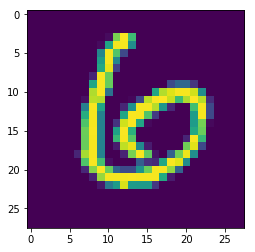

In [37]:
plt.imshow(mnist_values[11][0])


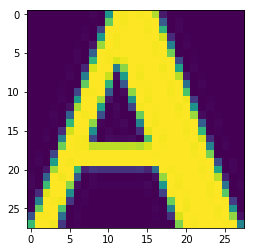

In [38]:
plt.imshow(notmnist_values_train[11][0])


In [14]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [52]:
class NetMnist_RELU(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=8*28*28, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = x.view(-1, 8*28*28)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x

    def fit(self, values_train, values_validate, labels_train, labels_validate, lr, epochs):
        trainloader = DataLoader(TensorDataset(values_train, labels_train), batch_size=32, shuffle=True)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.parameters(), lr=lr, momentum=0.9)
        
        best_loss, best_params = None, None
        for epoch in range(epochs):
            loss_sum = 0.0
            cnt = 0
            for inputs, labels in trainloader:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                loss_sum += loss.item()
                cnt += 1
            
            with torch.no_grad():
                loss_train = loss_sum / cnt
                loss_validate = criterion(self(values_validate), labels_validate).item()
                if best_params is None or loss_validate < best_loss:
                    best_params = [param.data.clone() for param in self.parameters()]
                    best_loss = loss_validate
                print("Epoch: " + str(epoch + 1) + "; train loss: " + str(loss_train) + "; validation loss: " + str(loss_validate))
        
        for i, param in enumerate(self.parameters()):
            param.data = best_params[i]
        
    def predict(self, values):
        with torch.no_grad():
            y_pred = self(values)
        _, pred = torch.max(y_pred, 1)
        return pred


In [53]:

class NetMnist_sigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=8*28*28, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 8*28*28)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        x = self.fc3(x)
        return x

    def fit(self, values_train, values_validate, labels_train, labels_validate, lr, epochs):
        trainloader = DataLoader(TensorDataset(values_train, labels_train), batch_size=32, shuffle=True)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.parameters(), lr=lr, momentum=0.9)
        
        best_loss, best_params = None, None
        for epoch in range(epochs):
            loss_sum = 0.0
            cnt = 0
            for inputs, labels in trainloader:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                loss_sum += loss.item()
                cnt += 1
            
            with torch.no_grad():
                loss_train = loss_sum / cnt
                loss_validate = criterion(self(values_validate), labels_validate).item()
                if best_params is None or loss_validate < best_loss:
                    best_params = [param.data.clone() for param in self.parameters()]
                    best_loss = loss_validate
                print("Epoch: " + str(epoch + 1) + "; train loss: " + str(loss_train) + "; validation loss: " + str(loss_validate))
        
        for i, param in enumerate(self.parameters()):
            param.data = best_params[i]
        
    def predict(self, values):
        with torch.no_grad():
            pred = self(values)
        _, pred = torch.max(pred, 1)
        return pred
    

In [54]:
class NetMnist_tanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=8*28*28, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.conv3(x)
        x = torch.tanh(x)
        x = x.view(-1, 8*28*28)
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.fc3(x)
        return x

    def fit(self, values_train, values_validate, labels_train, labels_validate, lr, epochs):
        trainloader = DataLoader(TensorDataset(values_train, labels_train), batch_size=32, shuffle=True)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.parameters(), lr=lr, momentum=0.9)
        
        best_loss, best_params = None, None
        for epoch in range(epochs):
            loss_sum = 0.0
            cnt = 0
            for inputs, labels in trainloader:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                loss_sum += loss.item()
                cnt += 1
            
            with torch.no_grad():
                loss_train = loss_sum / cnt
                loss_validate = criterion(self(values_validate), labels_validate).item()
                if best_params is None or loss_validate < best_loss:
                    best_params = [param.data.clone() for param in self.parameters()]
                    best_loss = loss_validate
                print("Epoch: " + str(epoch + 1) + "; train loss: " + str(loss_train) + "; validation loss: " + str(loss_validate))
        
        for i, param in enumerate(self.parameters()):
            param.data = best_params[i]
        
    def predict(self, values):
        with torch.no_grad():
            pred = self(values)
        _, pred = torch.max(pred, 1)
        return pred

In [58]:
mnist_values_train, mnist_values_test, mnist_values_validate, mnist_labels_train, mnist_labels_test, mnist_labels_validate = load_mnist_ttv_normalised()


F:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [56]:
def task6():
    nets_names = ["RELU", "TANH", "SIGMOID"]
    nets = [NetMnist_RELU(), NetMnist_tanh(), NetMnist_sigmoid()]
    for name, net in zip(nets_names, nets):
        print(name)
        net.fit(mnist_values_train, mnist_values_validate, mnist_labels_train, mnist_labels_validate, lr=0.01, epochs=20)
        print("Train: " + str((mnist_labels_train == net.predict(mnist_values_train)).sum().item() / mnist_values_train.shape[0]))
        print("Test: " + str((mnist_labels_test == net.predict(mnist_values_test)).sum().item() / mnist_values_test.shape[0]))
        print("Validate: " + str((mnist_labels_validate == net.predict(mnist_values_validate)).sum().item() / mnist_values_validate.shape[0]))
        print("-----------------------------------------\n")
        
task6()


RELU
Epoch: 1; train loss: 1.7832602772116661; validation loss: 0.7311576008796692
Epoch: 2; train loss: 0.429275617711246; validation loss: 0.31518176198005676
Epoch: 3; train loss: 0.22475565176457166; validation loss: 0.16622038185596466
Epoch: 4; train loss: 0.12255242489278316; validation loss: 0.1797269582748413
Epoch: 5; train loss: 0.10000296264886856; validation loss: 0.14848311245441437
Epoch: 6; train loss: 0.06512333523482085; validation loss: 0.13257195055484772
Epoch: 7; train loss: 0.03880321126431227; validation loss: 0.12035904824733734
Epoch: 8; train loss: 0.02863426201045513; validation loss: 0.17784518003463745
Epoch: 9; train loss: 0.021554518267512323; validation loss: 0.1280277967453003
Epoch: 10; train loss: 0.012595231123268604; validation loss: 0.1963225156068802
Epoch: 11; train loss: 0.025096449926495554; validation loss: 0.16468796133995056
Epoch: 12; train loss: 0.015122573375701904; validation loss: 0.14235273003578186
Epoch: 13; train loss: 0.0121666764

In [39]:
from skimage import io
import os
from pathlib import Path

def load_notmnist_ttv_normalised():
    root = data_folder + "notMNIST_small/"
    
    notmnist_values_train, notmnist_values_test, notmnist_values_validate, notmnist_labels_train, notmnist_labels_test, notmnist_labels_validate = None, None, None, None, None, None
    for i, letter in enumerate(os.listdir(root)):
        cur_notmnist_values = np.array([io.imread(img) for img in Path(root + letter).iterdir() if img.stat().st_size > 0], dtype=np.float)
        cur_notmnist_labels = np.array([i] * cur_notmnist_values.shape[0])
        cur_notmnist_values_train, cur_notmnist_values_test, cur_notmnist_labels_train, cur_notmnist_labels_test = split_dataset(cur_notmnist_values, cur_notmnist_labels)
        cur_notmnist_values_train, cur_notmnist_values_validate, cur_notmnist_labels_train, cur_notmnist_labels_validate = split_dataset(cur_notmnist_values_train, cur_notmnist_labels_train)
        
        if notmnist_values_train is None:
            notmnist_values_train, notmnist_labels_train = cur_notmnist_values_train, cur_notmnist_labels_train
            notmnist_values_test, notmnist_labels_test = cur_notmnist_values_test, cur_notmnist_labels_test
            notmnist_values_validate, notmnist_labels_validate = cur_notmnist_values_validate, cur_notmnist_labels_validate
        else:
            notmnist_values_train, notmnist_labels_train = np.vstack((notmnist_values_train, cur_notmnist_values_train)), np.hstack((notmnist_labels_train, cur_notmnist_labels_train))
            notmnist_values_test, notmnist_labels_test = np.vstack((notmnist_values_test, cur_notmnist_values_test)), np.hstack((notmnist_labels_test, cur_notmnist_labels_test))
            notmnist_values_validate, notmnist_labels_validate = np.vstack((notmnist_values_validate, cur_notmnist_values_validate)), np.hstack((notmnist_labels_validate, cur_notmnist_labels_validate))
    
    notmnist_values_train = torch.tensor(notmnist_values_train, dtype=torch.float).view(notmnist_values_train.shape[0], 1, 28, 28)
    notmnist_values_test = torch.tensor(notmnist_values_test, dtype=torch.float).view(notmnist_values_test.shape[0], 1, 28, 28)
    notmnist_values_validate = torch.tensor(notmnist_values_validate, dtype=torch.float).view(notmnist_values_validate.shape[0], 1, 28, 28)
    notmnist_labels_train = torch.tensor(notmnist_labels_train, dtype=torch.long)
    notmnist_labels_test = torch.tensor(notmnist_labels_test, dtype=torch.long)
    notmnist_labels_validate = torch.tensor(notmnist_labels_validate, dtype=torch.long)
    
    return notmnist_values_train, notmnist_values_test, notmnist_values_validate, notmnist_labels_train, notmnist_labels_test, notmnist_labels_validate


In [10]:
# 92 с разбега
class NetNotMnist_tanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=8*28*28, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.conv3(x)
        x = torch.tanh(x)
        x = x.view(-1, 8*28*28)
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.fc3(x)
        return x

    def fit(self, values_train, values_validate, labels_train, labels_validate, lr, epochs):
        trainloader = DataLoader(TensorDataset(values_train, labels_train), batch_size=32, shuffle=True)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.parameters(), lr=lr, momentum=0.9)
        
        best_loss, best_params = None, None
        for epoch in range(epochs):
            loss_sum = 0.0
            cnt = 0
            for inputs, labels in trainloader:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                loss_sum += loss.item()
                cnt += 1
            
            with torch.no_grad():
                loss_train = loss_sum / cnt
                loss_validate = criterion(self(values_validate), labels_validate).item()
                if best_params is None or loss_validate < best_loss:
                    best_params = [param.data.clone() for param in self.parameters()]
                    best_loss = loss_validate
                print("Epoch: " + str(epoch + 1) + "; train loss: " + str(loss_train) + "; validation loss: " + str(loss_validate))
        
        for i, param in enumerate(self.parameters()):
            param.data = best_params[i]
        
    def predict(self, values):
        with torch.no_grad():
            pred = self(values)
        _, pred = torch.max(pred, 1)
        return pred
    

In [40]:
notmnist_values_train, notmnist_values_test, notmnist_values_validate, notmnist_labels_train, notmnist_labels_test, notmnist_labels_validate = load_notmnist_ttv_normalised()

F:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [62]:
def task78():
    net = NetNotMnist_tanh()
    net.fit(notmnist_values_train, notmnist_values_validate, notmnist_labels_train, notmnist_labels_validate, lr=0.01, epochs=20)
    print("Train: " + str((notmnist_labels_train == net.predict(notmnist_values_train)).sum().item() / notmnist_values_train.shape[0]))
    print("Test: " + str((notmnist_labels_test == net.predict(notmnist_values_test)).sum().item() / notmnist_values_test.shape[0]))
    print("Validate: " + str((notmnist_labels_validate == net.predict(notmnist_values_validate)).sum().item() / notmnist_values_validate.shape[0]))
    print("-----------------------------------------\n")
    
task78()


Epoch: 1; train loss: 0.6257069088419278; validation loss: 0.36223742365837097
Epoch: 2; train loss: 0.32744329498211544; validation loss: 0.3244946599006653
Epoch: 3; train loss: 0.28527168566485245; validation loss: 0.31339049339294434
Epoch: 4; train loss: 0.23251892572641372; validation loss: 0.30337244272232056
Epoch: 5; train loss: 0.20653088599443437; validation loss: 0.31219619512557983
Epoch: 6; train loss: 0.17519005553921063; validation loss: 0.29146260023117065
Epoch: 7; train loss: 0.15118779238065083; validation loss: 0.26468315720558167
Epoch: 8; train loss: 0.13753916215896606; validation loss: 0.2694467306137085
Epoch: 9; train loss: 0.14503636415302754; validation loss: 0.3282550871372223
Epoch: 10; train loss: 0.14674538904428483; validation loss: 0.45297935605049133
Epoch: 11; train loss: 0.22321730995178224; validation loss: 0.33222925662994385
Epoch: 12; train loss: 0.1826889555454254; validation loss: 0.30726176500320435
Epoch: 13; train loss: 0.14369563572357097

In [41]:
from skimage.transform import rotate

def aug(values, labels):
        extended_values = []
        extended_labels = []
        for value, label in zip(values, labels):
            extended_values.append(value)
            extended_labels.append(label)
            
            extended_values.append(rotate(value, 10))
            extended_labels.append(label)
            
            extended_values.append(rotate(value, -10))
            extended_labels.append(label)
            
            """extended_values.append(rotate(value, 5))
            extended_labels.append(label)
            
            extended_values.append(rotate(value, -5))
            extended_labels.append(label)"""
        
        extended_values, extended_labels = np.array(extended_values), np.array(extended_labels)
        p = np.arange(extended_values.shape[0])
        np.random.shuffle(p)
        return extended_values[p], extended_labels[p]

In [42]:
def load_notmnist_ttv_normalised_2():
    root = data_folder + "notMNIST_small/"
    
    notmnist_values_train, notmnist_values_test, notmnist_values_validate, notmnist_labels_train, notmnist_labels_test, notmnist_labels_validate = None, None, None, None, None, None
    for i, letter in enumerate(os.listdir(root)):
        cur_notmnist_values = np.array([io.imread(img) for img in Path(root + letter).iterdir() if img.stat().st_size > 0], dtype=np.float)
        cur_notmnist_labels = np.array([i] * cur_notmnist_values.shape[0])
        cur_notmnist_values_train, cur_notmnist_values_test, cur_notmnist_labels_train, cur_notmnist_labels_test = split_dataset(cur_notmnist_values, cur_notmnist_labels)
        cur_notmnist_values_train, cur_notmnist_labels_train = aug(cur_notmnist_values_train, cur_notmnist_labels_train)
        cur_notmnist_values_train, cur_notmnist_values_validate, cur_notmnist_labels_train, cur_notmnist_labels_validate = split_dataset(cur_notmnist_values_train, cur_notmnist_labels_train)
        
        if notmnist_values_train is None:
            notmnist_values_train, notmnist_labels_train = cur_notmnist_values_train, cur_notmnist_labels_train
            notmnist_values_test, notmnist_labels_test = cur_notmnist_values_test, cur_notmnist_labels_test
            notmnist_values_validate, notmnist_labels_validate = cur_notmnist_values_validate, cur_notmnist_labels_validate
        else:
            notmnist_values_train, notmnist_labels_train = np.vstack((notmnist_values_train, cur_notmnist_values_train)), np.hstack((notmnist_labels_train, cur_notmnist_labels_train))
            notmnist_values_test, notmnist_labels_test = np.vstack((notmnist_values_test, cur_notmnist_values_test)), np.hstack((notmnist_labels_test, cur_notmnist_labels_test))
            notmnist_values_validate, notmnist_labels_validate = np.vstack((notmnist_values_validate, cur_notmnist_values_validate)), np.hstack((notmnist_labels_validate, cur_notmnist_labels_validate))
    
    notmnist_values_train = torch.tensor(notmnist_values_train, dtype=torch.float).view(notmnist_values_train.shape[0], 1, 28, 28)
    notmnist_values_test = torch.tensor(notmnist_values_test, dtype=torch.float).view(notmnist_values_test.shape[0], 1, 28, 28)
    notmnist_values_validate = torch.tensor(notmnist_values_validate, dtype=torch.float).view(notmnist_values_validate.shape[0], 1, 28, 28)
    notmnist_labels_train = torch.tensor(notmnist_labels_train, dtype=torch.long)
    notmnist_labels_test = torch.tensor(notmnist_labels_test, dtype=torch.long)
    notmnist_labels_validate = torch.tensor(notmnist_labels_validate, dtype=torch.long)
    
    return notmnist_values_train, notmnist_values_test, notmnist_values_validate, notmnist_labels_train, notmnist_labels_test, notmnist_labels_validate


In [43]:
notmnist_values_train, notmnist_values_test, notmnist_values_validate, notmnist_labels_train, notmnist_labels_test, notmnist_labels_validate = load_notmnist_ttv_normalised_2()


F:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [44]:
class NetNotMnist_95(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=1600, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        
        self.pool = nn.AvgPool2d(kernel_size=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.pool(x)
        #x = nn.Dropout(0.25)(x)
        x = x.view(-1, 1600)
        
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        #x = nn.Dropout(0.5)(x)
        x = self.fc3(x)
        return x

    def fit(self, values_train, values_validate, labels_train, labels_validate, lr, epochs):
        trainloader = DataLoader(TensorDataset(values_train, labels_train), batch_size=64, shuffle=True)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.parameters(), lr=lr, momentum=0.9)
        
        best_loss, best_params = None, None
        for epoch in range(epochs):
            loss_sum = 0.0
            cnt = 0
            for inputs, labels in trainloader:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                loss_sum += loss.item()
                cnt += 1
            
            print(epoch)
            with torch.no_grad():
                loss_validate = criterion(self(values_validate), labels_validate).item()
                if best_params is None or loss_validate < best_loss:
                    best_params = [param.data.clone() for param in self.parameters()]
                    best_loss = loss_validate
        
        for i, param in enumerate(self.parameters()):
            param.data = best_params[i]
        
    def predict(self, values):
        with torch.no_grad():
            pred = self(values)
        _, pred = torch.max(pred, 1)
        return pred

In [45]:
def task8():
    net = NetNotMnist_95()
    net.fit(notmnist_values_train, notmnist_values_validate, notmnist_labels_train, notmnist_labels_validate, lr=0.01, epochs=5)
    print("Train: " + str((notmnist_labels_train == net.predict(notmnist_values_train)).sum().item() / notmnist_values_train.shape[0]))
    print("Test: " + str((notmnist_labels_test == net.predict(notmnist_values_test)).sum().item() / notmnist_values_test.shape[0]))
    print("Validate: " + str((notmnist_labels_validate == net.predict(notmnist_values_validate)).sum().item() / notmnist_values_validate.shape[0]))
    print("-----------------------------------------\n")
    
task8()

0
1
2
3
4


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:62] data. DefaultCPUAllocator: not enough memory: you tried to allocate %dGB. Buy new RAM!12
